In [2]:
# Step 1: Import & Load Data
!pip -q install pulp ics

import os
import math
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pulp as pl


#Load diary data directly from GitHub
file_path = "https://raw.githubusercontent.com/zedda110088/time-allocation-optimizer/main/data/my_diary_30days.csv"
diary = pd.read_csv(file_path, parse_dates=["date"])
print("Loaded:", file_path, "Rows:", len(diary))
display(diary.head())



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 66.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 5.2 MB/s eta 0:00:00
Loaded: https://raw.githubusercontent.com/zedda110088/time-allocation-optimizer/main/data/my_diary_30days.csv Rows: 30


,date,Study,Sleep,Exercise,Research,Social,Efficiency
0,2025-08-01,5,8.4,0.0,0,0,2
1,2025-08-02,4,7.4,1.5,1,0,4
2,2025-08-03,3,7.9,0.0,1,0,3
3,2025-08-04,6,7.4,1.5,2,1,5
4,2025-08-05,5,8.4,1.0,2,1,5


In [3]:
#Build and Solve Optimization

# Define activity constraints
activities = pd.DataFrame({
    "activity": ["Classes","Study_1","Study_2","Study_3",
                 "Sleep","Exercise","Research_Project","Social"],
    "min_hours":[15, 0, 0, 0, 49, 0, 0, 0],
    "max_hours":[15,20,15,15, 56, 12,15,20],
    "utility_per_hour":[2.0,1.6,1.3,0.9, 1.8,1.1,1.3,0.7]
})

# Create LP model
model = pl.LpProblem("Time_Allocation", pl.LpMaximize)

# Define variables
h = {}
for _, row in activities.iterrows():
    name = row["activity"]
    h[name] = pl.LpVariable(f"h_{name}",
                            lowBound=float(row["min_hours"]),
                            upBound=float(row["max_hours"]))

# Objective
objective_terms = [float(row["utility_per_hour"]) * h[row["activity"]]
                   for _, row in activities.iterrows()]
model += pl.lpSum(objective_terms)

# Total time constraint
model += pl.lpSum(h.values()) == 168

# Solve
status = model.solve(pl.PULP_CBC_CMD(msg=False))
print("Solver status:", pl.LpStatus[status])

# Get results
opt_hours = {name: pl.value(var) for name, var in h.items()}
opt = pd.Series(opt_hours, name="opt_hours").sort_index()
print(opt)
print("Total hours =", opt.sum())


Solver status: Optimal
Classes             15.0
Exercise            12.0
Research_Project    15.0
Sleep               56.0
Social              20.0
Study_1             20.0
Study_2             15.0
Study_3             15.0
Name: opt_hours, dtype: float64
Total hours = 168.0


Baseline total hours: 113.51
Optimized total hours: 168.0


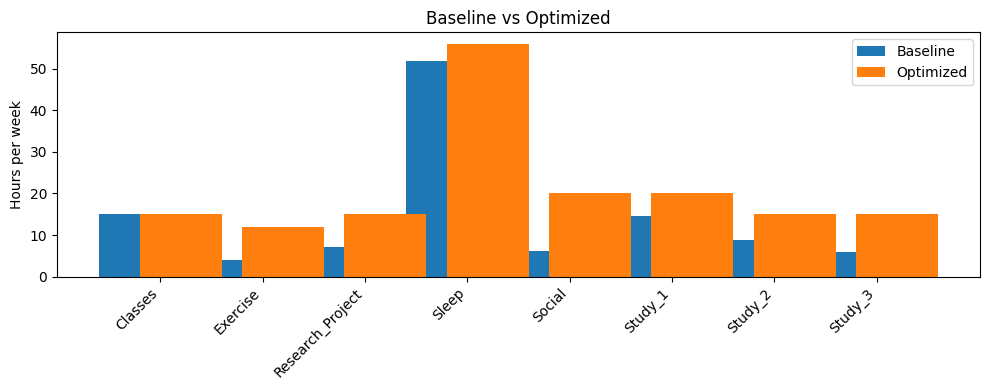

In [6]:
#Visualization

# Build Baseline from diary averages (fix names & split Study)

# get 30-day averages from diary
avg = diary[["Study","Sleep","Exercise","Research","Social"]].mean()

# map diary names -> activities names
#  - Research -> Research_Project
#  - split Study -> Study_1/2/3 by ratios (can tweak ratios)
study_total = float(avg.get("Study", 0.0))
r1, r2, r3 = 0.5, 0.3, 0.2
s1 = study_total * r1
s2 = study_total * r2
s3 = study_total * r3

baseline_dict = {
    "Classes": 15,
    "Sleep": float(avg.get("Sleep", 0.0)) * 7,
    "Exercise": float(avg.get("Exercise", 0.0)) * 7,
    "Research_Project": float(avg.get("Research", 0.0)) * 7,
    "Social": float(avg.get("Social", 0.0)) * 7,
    "Study_1": s1 * 7,
    "Study_2": s2 * 7,
    "Study_3": s3 * 7,
}

# make Series and align to activities
baseline = pd.Series(baseline_dict, name="baseline")
labels = sorted(activities["activity"].tolist())

# align baseline & optimized (opt) to same label order and fill missing with 0
b = baseline.reindex(labels).fillna(0)
o = opt.reindex(labels).fillna(0)

# quick sanity check
print("Baseline total hours:", round(b.sum(), 2))
print("Optimized total hours:", round(o.sum(), 2))

# plot side-by-side bars
plt.figure(figsize=(10, 4))
x = range(len(labels))
plt.bar(x, b.values, label="Baseline")
plt.bar([i+0.4 for i in x], o.values, label="Optimized")
plt.xticks([i+0.2 for i in x], labels, rotation=45, ha="right")
plt.ylabel("Hours per week")
plt.title("Baseline vs Optimized")
plt.legend()
plt.tight_layout()
plt.savefig("baseline_vs_optimized.png", dpi=300)
plt.show()





In [21]:

#Export to Calendar(.ics)

from datetime import datetime, timedelta
from ics import Calendar, Event

def export_opt_to_ics(opt: pd.Series,
                      filename="optimal_schedule.ics",
                      week_start=None,
                      day_start_hour=8):

    if week_start is None:
        today = datetime.utcnow().date()
        week_start = today + timedelta(days=(7 - today.weekday()) % 7)

    per_day = (opt / 7).to_dict()

    order = [a for a in ["Classes","Study_1","Study_2","Research_Project",
                         "Exercise","Study_3","Social","Sleep"]
             if a in per_day and per_day[a] > 1e-6]

    cal = Calendar()

    for d in range(7):
        day0 = datetime.combine(week_start + timedelta(days=d), datetime.min.time())

        cursor = day0 + timedelta(hours=day_start_hour)

        sleep_hours = 0.0

        for act in order:
            hours = float(per_day[act])
            if hours <= 0:
                continue
            if act == "Sleep":
                sleep_hours = hours
                continue

            e = Event(name=act)
            e.begin = cursor
            e.end = cursor + timedelta(hours=hours)
            cal.events.add(e)
            cursor = e.end
        if sleep_hours > 0:

            sleep_start = day0 + timedelta(hours=23 - max(0, sleep_hours - 1))
            e = Event(name="Sleep")
            e.begin = sleep_start
            e.end = sleep_start + timedelta(hours=sleep_hours)
            cal.events.add(e)


    with open(filename, "w") as f:
        f.writelines(cal.serialize_iter())
    print(f"ICS saved to: {filename}")
    return filename

ics_path = export_opt_to_ics(opt, filename="optimal_schedule.ics")

try:
    from google.colab import files
    files.download(ics_path)
except Exception as e:
    print("If you are not in a Colab environment, please manually download the file from the current working directory.", e)





ICS saved to: optimal_schedule.ics


/tmp/ipython-input-3706510529.py:10: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  today = datetime.utcnow().date()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>